In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.decomposition import PCA
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# logging for event tracking
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Let's read in the labels and article data, and construct a single dataframe to store them correspondingly. 
Note that the order of the articles are the same as the labels data, as they are all in sorted order of document names. 

In [3]:
# reading the labels file
import pandas as pd
df = pd.read_csv('jobs_data.csv')
df.head()

,Webindex,Title,Company,Description,Tokenized Description,Tokenized Title,Tokenized Company,Category
0,68997528,Finance / Accounts Asst Bromley to ****k,First Recruitment Services,Accountant (partqualified) to **** p.a. South ...,"['accountant', 'partqualified', 'south', 'east...","['finance', 'accounts', 'asst', 'bromley', 'to...","['first', 'recruitment', 'services']",Accounting_Finance
1,68063513,Fund Accountant Hedge Fund,Austin Andrew Ltd,One of the leading Hedge Funds in London is cu...,"['hedge', 'funds', 'london', 'recruiting', 'fu...","['fund', 'accountant', 'hedge', 'fund']","['austin', 'andrew', 'ltd']",Accounting_Finance
2,68700336,Deputy Home Manager,Caritas,An exciting opportunity has arisen to join an ...,"['exciting', 'arisen', 'establish', 'provider'...","['deputy', 'home', 'manager']",['caritas'],Healthcare_Nursing
3,67996688,Brokers Wanted Imediate Start,OneTwoTrade,OneTwoTrade is expanding their Sales Team and ...,"['expanding', 'recruiting', 'junior', 'trainee...","['brokers', 'wanted', 'imediate', 'start']",['onetwotrade'],Accounting_Finance
4,71803987,RGN Nurses (Hospitals) Penarth,Swiis Healthcare,RGN Nurses (Hospitals) Immediate fulltime and ...,"['rgn', 'nurses', 'hospitals', 'fulltime', 'pa...","['rgn', 'nurses', 'hospitals', 'penarth']","['swiis', 'healthcare']",Healthcare_Nursing


Read in the article text, and creates another list to store the tokenized version of the article text accordingly.

In [4]:
txt_fname = 'description.txt'
with open(txt_fname) as txtf:
    description = txtf.read().splitlines() # reading a list of strings, each for a document/article
tk_description = [a.split(' ') for a in description]

In [5]:
df['Description'] = description
df['Tokenized Description'] = tk_description
df.sample(n = 5) # look at a few examples

,Webindex,Title,Company,Description,Tokenized Description,Tokenized Title,Tokenized Company,Category
17,71213522,Marine Engines Specialist – Product Support,Webrecruit,marine engines specialist product annual bonus...,"[marine, engines, specialist, product, annual,...","['marine', 'engines', 'specialist', 'product',...",['webrecruit'],Engineering
146,71903625,"Graduate PA, Financial Services London",Coast Specialist Recruitment,boutique financial firm seeks graduate pa grou...,"[boutique, financial, firm, seeks, graduate, p...","['graduate', 'pa', 'financial', 'services', 'l...","['coast', 'specialist', 'recruitment']",Accounting_Finance
482,62017143,Team Manager,EMPLOYMENT SPECIALISTS LTD,major insurance group seeking recruit growing ...,"[major, insurance, group, seeking, recruit, gr...","['team', 'manager']","['employment', 'specialists', 'ltd']",Accounting_Finance
688,68711980,Finance Analyst,Exibio Financial Recruitment,experienced finance analyst large retail multi...,"[experienced, finance, analyst, large, retail,...","['finance', 'analyst']","['exibio', 'financial', 'recruitment']",Accounting_Finance
735,69587191,Senior Staff Nurse,Oxford University Hospitals NHS Trust,hospital senior staff nurse ref ng band pa hou...,"[hospital, senior, staff, nurse, ref, ng, band...","['senior', 'staff', 'nurse']","['oxford', 'university', 'hospitals', 'nhs', '...",Healthcare_Nursing


In [6]:
words = list(chain.from_iterable(tk_description))
# set of unique words
vocab = sorted(list(set(words)))
# total number

### Bag Of Words Model

#### Creating Binary Vectors

In [7]:
# Code to perform the task...
joined_description = [' '.join(review) for review in tk_description]
bVectorizer = CountVectorizer(analyzer = "word",binary = True,vocabulary = vocab) # initialise the CountVectorizer
binary_features = bVectorizer.fit_transform(joined_description)
binary_features.shape

(776, 5168)

#### Creating Count Vectors

In [8]:
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # initialised the CountVectorizer
count_features = cVectorizer.fit_transform(joined_description)
count_features.shape

(776, 5168)

In [9]:
count_features_df = pd.DataFrame(count_features.toarray(), columns=cVectorizer.get_feature_names_out())
# print out samples
count_features_df.head(3)

,aap,aaron,aat,abb,abenefit,aberdeen,abi,abilities,abreast,abroad,...,years,yeovil,yn,york,yorkshire,youmust,young,younger,yrs,zest
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Saving it into the file

In [10]:
webindex = df['Webindex']
count_features = cVectorizer.fit_transform(joined_description).toarray()

def save_count_vector(count_features, webindex, filename):
    with open(filename, 'w') as f:
        for i in range(len(count_features)):
            f.write('#' + str(webindex[i]) + ',')
            for j in range(len(count_features[i])):
                if count_features[i][j] != 0:
                    f.write(str(j) + ':' + str(count_features[i][j]) + ',')
            f.write('\n')
    f.close()
    print('Count vector representation saved to ' + filename)


save_count_vector(count_features, webindex, 'count_vectors.txt')

Count vector representation saved to count_vectors.txt


#### Creating TF-IDF Vectors

In [11]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform(joined_description) # generate the tfidf vector representation for all articles
tfidf_features.shape

(776, 5168)

In [12]:
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each article by index
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write("{}:{} ".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file  

In [13]:
tfidf_features_file = "jobs_data_vector.txt" # file name of the tfidf vector

write_vectorFile(tfidf_features,tfidf_features_file) # write the tfidf vector to file

## Creating Model based on word embeddings

#### Creating and Saving FastText Model

In [14]:
def gen_docVecs(wv,tk_txts):
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # if we haven't pre-processed the articles, it's a good idea to remove stop words

    for i in range(0,len(tk_txts)):
        tokens = tk_txts[i]
        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = pd.concat([temp, pd.Series(word_vec)], ignore_index = True)
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column
        docs_vectors = pd.concat([docs_vectors, doc_vector], ignore_index = True)
    return docs_vectors

def docvecs(embeddings, docs):
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        docvec = np.vstack([embeddings[term] for term in valid_keys])
        """
        Note: using `sum` here, other 'pooling' options are possible too,
        e.g. mean, etc.
        """
        docvec = np.sum(docvec, axis=0)
        vecs[i,:] = docvec
    return vecs

import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(3891013)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

In [31]:
from gensim.models.fasttext import FastText

# 1. Set the corpus file names/path
corpus_file = 'description.txt'

# 2. Initialise the Fast Text model
bbcFT = FastText(vector_size=50) 

# 3. build the vocabulary
bbcFT.build_vocab(corpus_file=corpus_file)

# 4. train the model
bbcFT.train(
    corpus_file=corpus_file, epochs=bbcFT.epochs,
    total_examples=bbcFT.corpus_count, total_words=bbcFT.corpus_total_words,
)

# print(bbcFT)

# Defining values for parameters

from gensim.models import FastText
import multiprocessing

# embedding_size = 300
# window_size = 5
# min_word = 3
# down_sampling = 1e-3

# num_cores = multiprocessing.cpu_count()

# bbcFT = FastText(df['Tokenized Description'],
#                       vector_size=embedding_size,
#                       window=window_size,
#                       min_count=min_word,
#                       sample=down_sampling,
#                       workers=num_cores,  # Use all available cores
#                       sg=1,
#                       epochs=100)



2023-09-28 04:01:17,463 : INFO : FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=50, alpha=0.025>', 'datetime': '2023-09-28T04:01:17.463378', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'created'}
2023-09-28 04:01:17,465 : INFO : collecting all words and their counts
2023-09-28 04:01:17,466 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-09-28 04:01:17,481 : INFO : collected 5168 word types from a corpus of 81205 raw words and 776 sentences
2023-09-28 04:01:17,482 : INFO : Creating a fresh vocabulary
2023-09-28 04:01:17,487 : INFO : FastText lifecycle event {'msg': 'effective_min_count=5 retains 2741 unique words (53.04% of original 5168, drops 2427)', 'datetime': '2023-09-28T04:01:17.487359', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'prepare

In [32]:
bbcFT_wv = bbcFT.wv
print(bbcFT_wv)

FastTextKeyedVectors<vector_size=50, 2741 keys>


In [33]:
# Save the model
bbcFT.save("models/FastText/bbcFT.model")

2023-09-28 04:01:23,298 : INFO : FastText lifecycle event {'fname_or_handle': 'models/FastText/bbcFT.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-09-28T04:01:23.298965', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'saving'}
2023-09-28 04:01:23,300 : INFO : storing np array 'vectors_ngrams' to models/FastText/bbcFT.model.wv.vectors_ngrams.npy
2023-09-28 04:01:23,406 : INFO : not storing attribute vectors
2023-09-28 04:01:23,407 : INFO : not storing attribute buckets_word
2023-09-28 04:01:23,407 : INFO : not storing attribute cum_table
2023-09-28 04:01:23,409 : INFO : saved models/FastText/bbcFT.model


We can retrieve the KeyedVectors from the model as follows,

In [34]:
# loading the trained Fasttext model based on bbc News data
from gensim.models.fasttext import FastText
bbcFT = FastText.load("models/FastText/bbcFT.model")
print(bbcFT)
bbcFT_wv= bbcFT.wv

2023-09-28 04:01:24,335 : INFO : loading FastText object from models/FastText/bbcFT.model
2023-09-28 04:01:24,337 : INFO : loading wv recursively from models/FastText/bbcFT.model.wv.* with mmap=None
2023-09-28 04:01:24,338 : INFO : loading vectors_ngrams from models/FastText/bbcFT.model.wv.vectors_ngrams.npy with mmap=None
2023-09-28 04:01:24,397 : INFO : setting ignored attribute vectors to None
2023-09-28 04:01:24,397 : INFO : setting ignored attribute buckets_word to None
2023-09-28 04:01:24,454 : INFO : setting ignored attribute cum_table to None
2023-09-28 04:01:24,462 : INFO : FastText lifecycle event {'fname': 'models/FastText/bbcFT.model', 'datetime': '2023-09-28T04:01:24.462742', 'gensim': '4.3.2', 'python': '3.8.18 (default, Sep 11 2023, 08:17:16) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'loaded'}


FastText<vocab=2741, vector_size=50, alpha=0.025>


In [35]:
# NOTE this can take some time to finish running
# generate document embeddings
bbcFT_dvs = gen_docVecs(bbcFT_wv,df['Tokenized Description'])
bbcFT_dvs.isna().any().sum()

0

In [36]:
"""Note: use `docvecs` version
"""
bbcFT_dvs = docvecs(bbcFT_wv, df['Tokenized Description'])

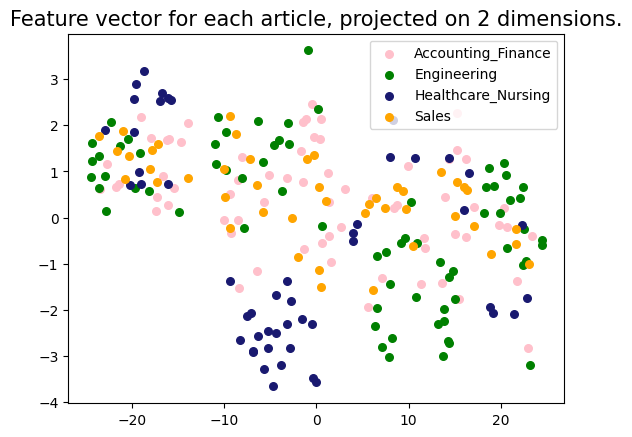

In [37]:
# explore feature space
features = bbcFT_dvs
plotTSNE(df['Category'],features)

er~~~ for some categories seems a bit messy also.....

In [38]:
# build the classfication model and report results
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcFT_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=3891013)

model = LogisticRegression(max_iter = 100,random_state=3891013)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7704280155642024

## 4. Generating TF-IDF weighted document vectors

Ok, I hope you have lots of fun building document embeddings based on varoius word embedding models. 
Previously, when we generate the document embeddings, we just sum up the embeddings vector of each tokenized word in the article, a bit simplicity 🤔

In this section, let's make it a bit more challenging, we are going to build the tf-idf document embeddings. 
What does that mean? 🤨
Hmm~~ it's not magic, we just do a weigthed sum of the word embedding vectors, however, the weight here, refers to the tf-idf weight of the word. 

If you already forgot about what is `tf-idf`, please refer to Activity 3 Pre-processing Text and Generating Features. 
Otherwise, move on!
So we've generated the tf-idf vector representation of documents in Activity 3 and saved in a txt file called `bbcNews_tVector.txt`. The format of this file is:
- each line represents an article;
- each line is of the format 'w_index:weight w_index:weight ......' 

Oh, but we don't have that word index `w_index` here in this activity, what should we do? 🤔
ah ha, we also saved the vocabulary in a file `bbcNews_voc`, in which each line is a word, and of the format `index,word`. 
Theresore, based on these two files, we can create a word:weight mapping for each tokenized word in a document!

Ok, in the following couple block of codes, this is exactly what we are trying to do, step by step. 
- the `gen_vocIndex` function reads the the vocabulary file, and create an w_index:word dictionary

In [39]:
def gen_vocIndex(voc_fname):
    with open(voc_fname) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] # each line is 'index,word'
    return {int(vi[1]):vi[0] for vi in voc_Ind}


# Generates the w_index:word dictionary
voc_fname = 'vocab.txt' # path for the vocabulary
voc_dict = gen_vocIndex(voc_fname)
voc_dict

{0: 'aap',
 1: 'aaron',
 2: 'aat',
 3: 'abb',
 4: 'abenefit',
 5: 'aberdeen',
 6: 'abi',
 7: 'abilities',
 8: 'abreast',
 9: 'abroad',
 10: 'absence',
 11: 'absolute',
 12: 'ac',
 13: 'aca',
 14: 'academic',
 15: 'academy',
 16: 'acca',
 17: 'accept',
 18: 'acceptable',
 19: 'acceptance',
 20: 'accepted',
 21: 'access',
 22: 'accessible',
 23: 'accident',
 24: 'accommodates',
 25: 'accommodation',
 26: 'accomplished',
 27: 'accordance',
 28: 'account',
 29: 'accountabilities',
 30: 'accountability',
 31: 'accountable',
 32: 'accountancy',
 33: 'accountant',
 34: 'accountants',
 35: 'accounting',
 36: 'accounts',
 37: 'accreditation',
 38: 'accredited',
 39: 'accruals',
 40: 'accuracy',
 41: 'accurate',
 42: 'accurately',
 43: 'achievable',
 44: 'achieve',
 45: 'achieved',
 46: 'achievement',
 47: 'achievements',
 48: 'achiever',
 49: 'achieving',
 50: 'acii',
 51: 'acquired',
 52: 'acquisition',
 53: 'acquisitions',
 54: 'act',
 55: 'acting',
 56: 'action',
 57: 'actions',
 58: 'action

- the `doc_wordweights` function takes the tfidf document vector file, as well as the w_index:word dictionary, creates the mapping between w_index and the actual word, and creates a dictionary of word:weight or each unique word appear in the document.

In [40]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = 'jobs_data_vector.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)

In [41]:
# take a look at the tfidf word weights dictionary of the first document
tfidf_weights[0]

{'terms': '0.1308521762366382',
 'south': '0.20612279476719383',
 'requirement': '0.1249811292375601',
 'reconciliation': '0.14183179957804745',
 'qualified': '0.07821166567368464',
 'purchase': '0.13660500449583682',
 'previous': '0.08245826258151072',
 'possess': '0.10970668693524623',
 'phone': '0.11922830097836144',
 'person': '0.09046563231320097',
 'permanent': '0.08174449947711492',
 'payment': '0.13824362212075778',
 'partqualified': '0.173326820839609',
 'part': '0.07189780182251101',
 'offices': '0.11518385918795168',
 'negotiating': '0.15985275501239027',
 'modern': '0.13218581222143622',
 'manufacturing': '0.09726367012728679',
 'london': '0.16839249893971672',
 'letter': '0.12835773375082868',
 'ledger': '0.27321000899167364',
 'ideal': '0.08802432794046589',
 'handling': '0.24392130714952515',
 'fully': '0.1061919231001392',
 'exceptional': '0.12835773375082868',
 'email': '0.07884175705492424',
 'east': '0.20514266820633364',
 'duties': '0.08294417258358575',
 'debts': '

Ok, once we have the word:weight dictionary of each document, now we can construct the tf-idf weighted document embeddings. 
* the following `gen_docVecs` function is an revision/extension of the previous written function, that takes the word embeddings dictionary, the tokenized text of articles, and the tfidf weights (list of word:weight dictionaries, one for each article) as arguments, and generates the document embeddings:
 1. creates an empty dataframe `docs_vectors` to store the document embeddings of articles
  2. it loop through every tokenized text:
    - creates an empty dataframe `temp` to store all the word embeddings of the article
    - for each word that exists in the word embeddings dictionary/keyedvectors, 
        - if the argument `tfidf` weights are empty `[]`, it sets the weight of the word as 1
        - otherwise, retrieve the weight of the word from the corresponding word:weight dictionary of the article from  `tfidf`
    - row bind the weighted word embedding to `temp`
    - takes the sum of each column to create the document vector, i.e., the embedding of an article
    - append the created document vector to the list of document vectors

In [42]:
# extended version of the `gen_docVecs` function
def gen_docVecs(wv,tk_txts):
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # if we haven't pre-processed the articles, it's a good idea to remove stop words

    for i in range(0,len(tk_txts)):
        tokens = tk_txts[i]
        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = pd.concat([temp, pd.Series(word_vec)], ignore_index = True)
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column
        docs_vectors = pd.concat([docs_vectors, doc_vector], ignore_index = True)
    return docs_vectors

In [43]:
"""
Note: a faster version of the extended `gen_docVecs`.
"""
def weighted_docvecs(embeddings, tfidf, docs):
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        tf_weights = [float(tfidf[i].get(term, 0.)) for term in valid_keys]
        assert len(valid_keys) == len(tf_weights)
        weighted = [embeddings[term] * w for term, w in zip(valid_keys, tf_weights)]
        docvec = np.vstack(weighted)
        """
        Note: using `sum` here, other 'pooling' options are possible too,
        e.g. mean, etc.
        """
        docvec = np.sum(docvec, axis=0)
        vecs[i,:] = docvec
    return vecs

Ok we now have everything ready to generate the weight document embeddings. 
We can do this on any of our previous explored models, including the pretrained Word2Vec GoogleNews300, Glove, our in-house trained Word2Vec and FastText.

Let's generated the weighted version of the document embedding vectors first

In [44]:
"""Note: use `weighted_docvecs` version
"""
# weighted_preTW2v_dvs = weighted_docvecs(preTW2v_wv, tfidf_weights, df['Tokenized Description'])
# weighted_preTGloVe_dvs = weighted_docvecs(preTGloVe_wv, tfidf_weights, df['Tokenized Description'])
# weighted_bbcW2v_dvs = weighted_docvecs(bbcW2v_wv, tfidf_weights, df['Tokenized Description'])
weighted_bbcFT_dvs = weighted_docvecs(bbcFT_wv, tfidf_weights, df['Tokenized Description'])

And we can do very much the same thing as what we do before for other models. 
Here, we will do this as loops, for each model:
- we plot out the feature vectors  projected in a 2-dimensional space,then 
- we build the logistic regression model for document classfication and report the model performance.

Weighted Pretrained Word2Vec: tSNE 2 dimensional projected Feature space


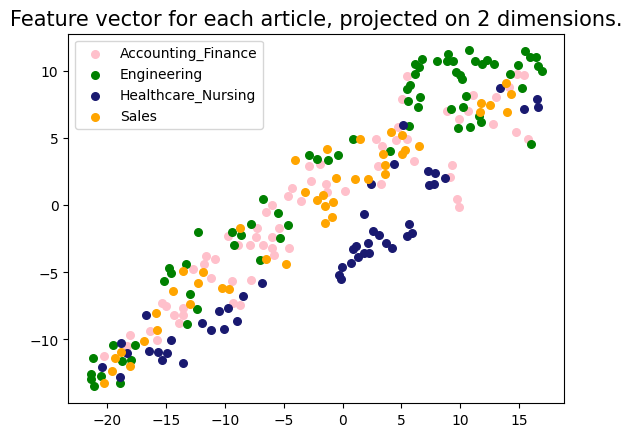

Accuracy:  0.7704280155642024





In [45]:
%matplotlib inline
seed = 3891013
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models = [weighted_bbcFT_dvs]
model_names = ["Weighted Pretrained Word2Vec", "Weighted Pretrained GloVe", "Weighted In-house Word2Vec","Weighted In-house FastText"]
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    # features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    features = dv
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(df['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=3891013)

    model = LogisticRegression(max_iter = 2000,random_state=3891013)
    model.fit(X_train, y_train)
    print("Accuracy: ", model.score(X_test, y_test))
    print('\n\n')